# ⚛️ VQE Ground-State Simulation of H₂  
### **Manual UCCSD vs Packaged VQE Engine (Noiseless)**

This notebook provides a **two-part educational walkthrough**:

---

## **Part 1 — Manual VQE (Educational UCCSD from Scratch)**  
You will implement the entire VQE workflow manually:

- Build the molecular Hamiltonian  
- Compute Hartree–Fock reference  
- Generate UCCSD single & double excitations  
- Construct the UCCSD ansatz *yourself*  
- Optimize using multiple PennyLane optimizers  
- Plot energy convergence  
- Reconstruct the ground state and plot amplitudes  

This section is ideal for learning *how* VQE works internally.

---

## **Part 2 — Using the Packaged VQE Engine (`vqe.core.run_vqe`)**  
You run the same simulation using your **production-ready VQE module**:

- One function call  
- Built-in caching  
- Built-in plotting  
- Built-in state reconstruction  
- Reproducible configuration hashing  
- Automatically saved JSON + image outputs  

This section mirrors the results from Part 1 and demonstrates how your package
should be used in real research workflows.

---

The two sections together provide a **complete educational + practical** treatment
of VQE applied to the H₂ molecule.


In [1]:
# Core scientific stack
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
from pennylane.qchem import excitations

import matplotlib.pyplot as plt
import json, time, os, sys

# Allow importing our VQE package modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# From notebooks/vqe/vqe_utils.py
from vqe.vqe_utils import (
    get_optimizer,
    excitation_ansatz,
    set_seed,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    ensure_dirs,
    build_run_filename,
    IMG_DIR,
    OPTIMIZERS,
)

# From packaged VQE engine for Part 2
from vqe.core import run_vqe

ensure_dirs()
set_seed(0)

# 🧩 Part 1 — Manual VQE Implementation (Educational UCCSD)

In this section, you will construct:

1. The molecular Hamiltonian manually  
2. The UCCSD excitations  
3. The VQE ansatz circuit  
4. The cost function  
5. The optimization loop over many classical optimizers  
6. State reconstruction

This is the **full internal logic** behind VQE.


In [2]:
# Molecular parameters
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.7414],
])

basis = "sto-3g"
electrons = 2

# Build Hamiltonian
hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, basis=basis, charge=0
)

print("Number of qubits:", qubits)

# Hartree–Fock reference
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)
print("Hartree–Fock state:", "|" + "".join(str(int(b)) for b in hf) + "⟩")

Number of qubits: 4
Hartree–Fock state: |1100⟩


In [3]:
dev = qml.device("default.qubit", wires=qubits)

@qml.qnode(dev)
def hf_energy(state):
    qml.BasisState(np.array(state, dtype=int), wires=range(qubits))
    return qml.expval(hamiltonian)

E_HF = hf_energy(hf)
print("HF Energy:", float(E_HF), "Ha")

HF Energy: -0.8884230416458276 Ha


In [4]:
singles, doubles = excitations(electrons, qubits)

print("Singles:", singles)
print("Doubles:", doubles)

n_params = len(singles) + len(doubles)
print("Total UCCSD parameters:", n_params)

Singles: [[0, 2], [1, 3]]
Doubles: [[0, 1, 2, 3]]
Total UCCSD parameters: 3


## Cost Function

We construct a UCCSD ansatz using `excitation_ansatz()` from `vqe_utils.py`.
This applies:

- Hartree–Fock reference  
- All single excitations  
- All double excitations  

Then measures:

$$
E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle
$$


In [5]:
@qml.qnode(dev)
def cost_function(params):
    excitation_ansatz(
        params,
        wires=range(qubits),
        hf_state=hf,
        excitations=(singles, doubles),
        excitation_type="both",
    )
    return qml.expval(hamiltonian)



## Running VQE with Manual Optimization  
We loop over all optimizers defined in:

```python
OPTIMIZERS = {
    "Adam": qml.AdamOptimizer,
    "GradientDescent": qml.GradientDescentOptimizer,
    "Nesterov": qml.NesterovMomentumOptimizer,
    "Adagrad": qml.AdagradOptimizer,
    "Momentum": qml.MomentumOptimizer,
    "SPSA": qml.SPSAOptimizer,
}
```

We:
- Initialize parameters
- Optimize for `max_iters = 50`
- Store final parameters and energy
- Cache results on disk

In [6]:
results_manual = {}

max_iters = 50
stepsize = 0.1
seed = 0

for opt_name in OPTIMIZERS:
    print(f"\n🔧 Running manual VQE with optimizer: {opt_name}")

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc="Manual-UCCSD",
        optimizer_name=opt_name,
        stepsize=stepsize,
        max_iterations=max_iters,
        seed=seed,
    )

    sig = run_signature(cfg)
    fname = build_run_filename("H2_Manual", opt_name, seed, sig)
    existing = find_existing_run(sig)

    if existing:
        print(f"[reuse] Loaded cached run at {existing}")
        with open(existing) as f:
            rec = json.load(f)
        energies = rec["energies"]
        params = np.array(rec["final_params"], requires_grad=True)
    else:
        params = np.zeros(n_params, requires_grad=True)
        energies = [float(cost_function(params))]
        opt = get_optimizer(opt_name, stepsize)

        for _ in range(max_iters):
            params, e_prev = opt.step_and_cost(cost_function, params)
            energies.append(float(e_prev))

        record = {
            "config": cfg,
            "energies": energies,
            "final_params": params.tolist(),
        }
        save_run_record(fname, record)
        print(f"[saved] {fname}")

    results_manual[opt_name] = {"energies": energies, "params": params}


🔧 Running manual VQE with optimizer: Adam
[reuse] Loaded cached run at /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Manual_Adam_s0__3eb1e0e2fe9e.json

🔧 Running manual VQE with optimizer: GradientDescent
[reuse] Loaded cached run at /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Manual_GradientDescent_s0__739b901f5da3.json

🔧 Running manual VQE with optimizer: Nesterov
[reuse] Loaded cached run at /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Manual_Nesterov_s0__71632690079e.json

🔧 Running manual VQE with optimizer: Adagrad
[reuse] Loaded cached run at /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Manual_Adagrad_s0__312dc22f30a4.json

🔧 Running manual VQE with optimizer: Momentum
[reuse] Loaded cached run at /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Manual_Momentum_s0__37160175b142.json

🔧 Running manual VQE with optimizer: SPSA
[reuse] Loaded cached run at /workspaces/Variational_Quantum_Ei

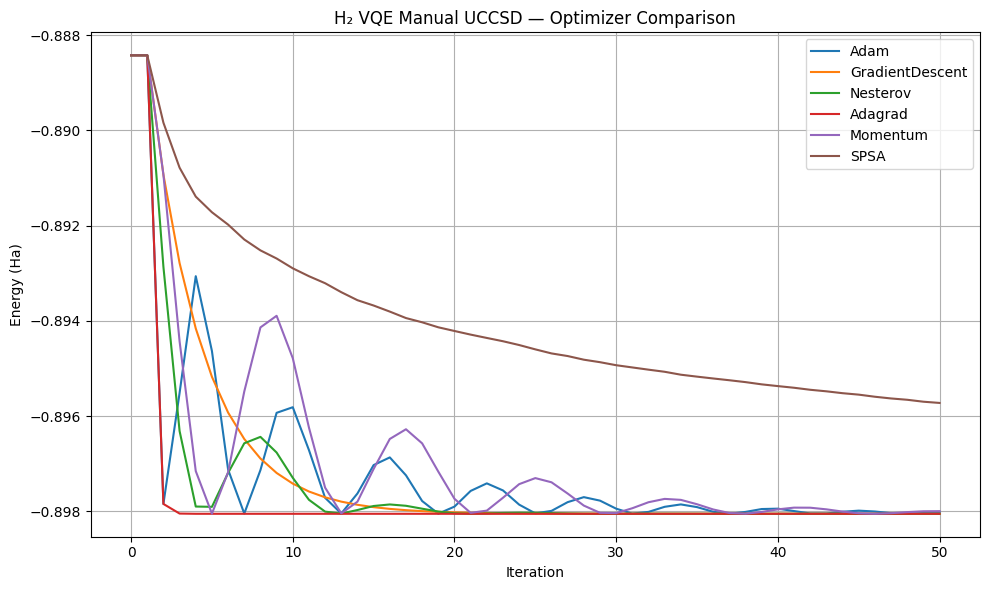

In [7]:
plt.figure(figsize=(10,6))

for name, res in results_manual.items():
    plt.plot(res["energies"], label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ VQE Manual UCCSD — Optimizer Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Manual_Optimizer_Comparison.png", dpi=300)
plt.show()

In [8]:
best_opt = min(results_manual, key=lambda n: results_manual[n]["energies"][-1])
best_params = results_manual[best_opt]["params"]

print(f"Best optimizer: {best_opt}")

@qml.qnode(dev)
def final_state(params):
    excitation_ansatz(params, wires=range(qubits), hf_state=hf,
                      excitations=(singles, doubles), excitation_type="both")
    return qml.state()

psi = final_state(best_params)
threshold = 1e-2
nz = np.where(np.abs(psi) > threshold)[0]

print("\nNon-zero amplitudes:")
for idx in nz:
    print(f"{idx:0{qubits}b} : {psi[idx]}")

Best optimizer: Adagrad

Non-zero amplitudes:
0011 : (-0.05854512719726701+0j)
1100 : (0.9982847630217822+0j)


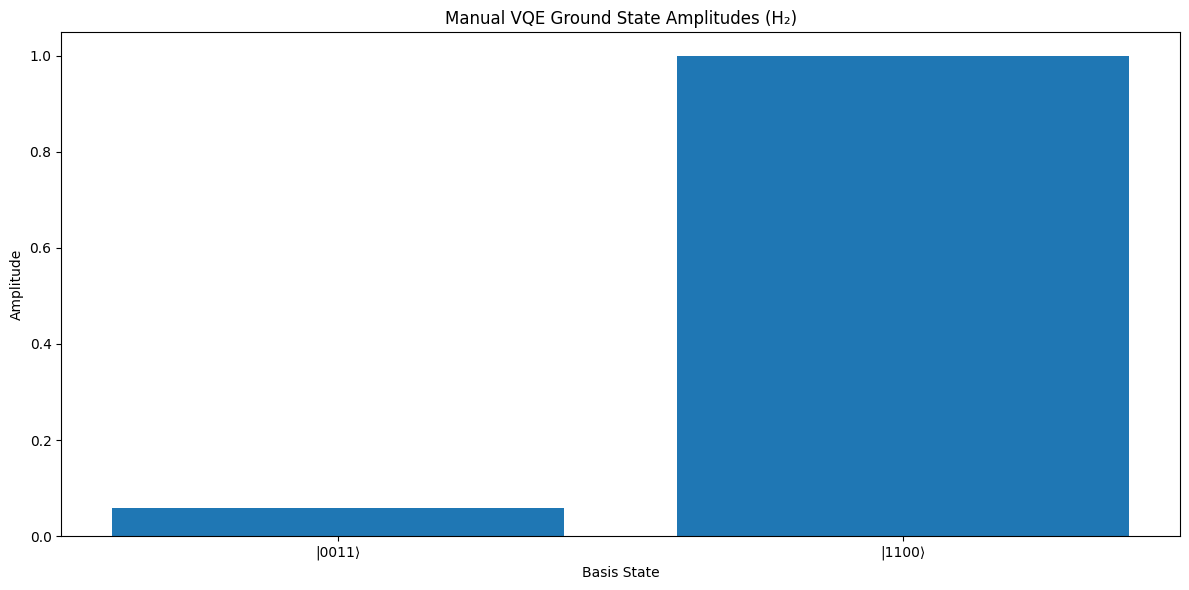

In [9]:
labels = [f"|{i:0{qubits}b}⟩" for i in nz]
amps = np.abs(psi[nz])

plt.figure(figsize=(12,6))
plt.bar(labels, amps)
plt.xlabel("Basis State")
plt.ylabel("Amplitude")
plt.title("Manual VQE Ground State Amplitudes (H₂)")
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Manual_State.png", dpi=300)
plt.show()

# 🟦 Part 2 — Using the Packaged VQE Engine (`vqe.core.run_vqe`)

This section runs **the same problem**, but using your production-ready API.

### Benefits:
- Automatic caching
- Automatic JSON output
- Device + ansatz + optimizer all handled for you
- Cleaner, shorter code
- Matches structure of all other notebooks

We now repeat the optimizer comparison using:

```python
from vqe.core import run_vqe
```

In [10]:
results_pkg = {}

for opt_name in OPTIMIZERS:
    print(f"\n⚙️ run_vqe with optimizer: {opt_name}")

    rec = run_vqe(
        molecule="H2",
        ansatz_name="UCCSD",
        optimizer_name=opt_name,
        n_steps=50,
        stepsize=0.1,
        noisy=False,
        plot=False,
        seed=0,
    )

    results_pkg[opt_name] = rec["energies"]


⚙️ run_vqe with optimizer: Adam

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s0__307dfaa7da89.json

⚙️ run_vqe with optimizer: GradientDescent

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__GradientDescent__VQE__noiseless__s0__eabc504bf6d9.json

⚙️ run_vqe with optimizer: Nesterov

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Nesterov__VQE__noiseless__s0__3dce26c1e235.json

⚙️ run_vqe with optimizer: Adagrad

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adagrad__VQE__noiseless__s0__365363242870.json

⚙️ run_vqe with optimizer: Momentum

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Momentum__VQE__noiseless__s0__7e405c7f2654.json

⚙️ run_vqe with optimizer: SPSA

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_

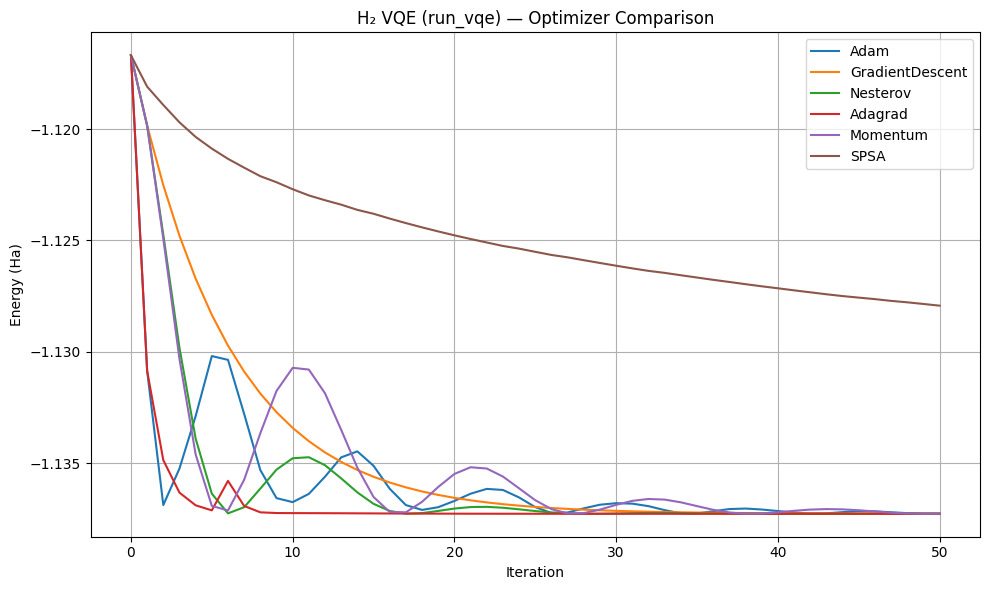

In [11]:
plt.figure(figsize=(10,6))

for name, energies in results_pkg.items():
    plt.plot(energies, label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ VQE (run_vqe) — Optimizer Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Package_Optimizer_Comparison.png", dpi=300)
plt.show()

In [12]:
best_pkg = min(results_pkg, key=lambda n: results_pkg[n][-1])

print("Best package optimizer:", best_pkg)

res = run_vqe(
    molecule="H2",
    ansatz_name="UCCSD",
    optimizer_name=best_pkg,
    n_steps=50,
    stepsize=0.1,
    noisy=False,
    plot=False,
    seed=0,
)

psi_re = np.array(res["final_state_real"])
psi_im = np.array(res["final_state_imag"])
psi_pkg = psi_re + 1j * psi_im

nz_pkg = np.where(np.abs(psi_pkg) > 1e-2)[0]
for idx in nz_pkg:
    print(f"{idx:0{qubits}b} : {psi_pkg[idx]}")

Best package optimizer: Adagrad

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adagrad__VQE__noiseless__s0__365363242870.json
0011 : (-0.11282736848339227+0j)
1100 : (0.9936146054753315+0j)


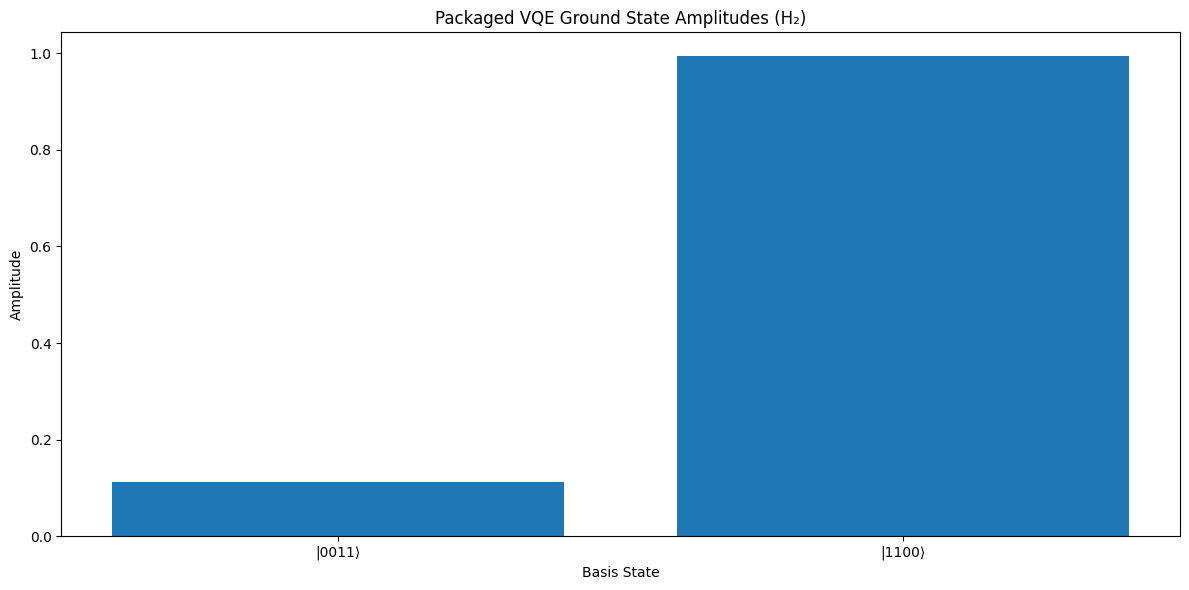

In [13]:
labels = [f"|{i:0{qubits}b}⟩" for i in nz_pkg]
amps = np.abs(psi_pkg[nz_pkg])

plt.figure(figsize=(12,6))
plt.bar(labels, amps)
plt.xlabel("Basis State")
plt.ylabel("Amplitude")
plt.title("Packaged VQE Ground State Amplitudes (H₂)")
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Package_State.png", dpi=300)
plt.show()